In [1]:
import os
import h5py
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from matplotlib import rcParams
# Set font to Arial
rcParams['font.family'] = 'Arial'
from matplotlib.ticker import MultipleLocator

from scipy.interpolate import griddata

import json

from matplotlib import widgets

# Stackreg Regstrations
# https://pypi.org/project/pystackreg/
from pystackreg import StackReg

#Phase cross correlation
from skimage import data
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from scipy.ndimage import fourier_shift
from skimage.registration._phase_cross_correlation import _upsampled_dft
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform

import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter1d

from ipywidgets import interact, widgets

from skimage import filters
from skimage import morphology
from skimage.segmentation import watershed

import cv2

C:\Users\yamamoto\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Define helper functions

In [2]:
def overlayImages(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = np.stack(imgs, axis=0)

    return aggregator(imgs, axis=0)


def compositeImages(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = [img / img.max() for img in imgs]

    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3-len(imgs))

    imgs = np.dstack(imgs)

    return imgs

transformations = {
    'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
    'AFFINE': StackReg.AFFINE,
    'BILINEAR': StackReg.BILINEAR
}

def alignStackReg(image1, image2):
    
    sr = StackReg(StackReg.TRANSLATION)
    aligned_image2 = sr.register_transform(image1,image2)
    
    return image1,aligned_image2

def alignePhaseCrossCorr(image1,image2):
        
    vec, err, _ = phase_cross_correlation(image1, image2, upsample_factor=100)
   
    fft_image2 = np.fft.fftn(image2)
    shifted_fft_image2 = fourier_shift(fft_image2, vec)
    shifted_ifft_image2 = np.fft.ifftn(shifted_fft_image2)

    print(vec)
    return image1,shifted_ifft_image2.real

def alignPhaseCrossCorr_crop(image1,image2, x0, x1, y0, y1):
        
    vec, err, _ = phase_cross_correlation(image1[y0:y1,x0:x1], image2[y0:y1,x0:x1], upsample_factor=100)
   
    fft_image2 = np.fft.fftn(image2)
    shifted_fft_image2 = fourier_shift(fft_image2, vec)
    shifted_ifft_image2 = np.fft.ifftn(shifted_fft_image2)
    
    print(vec)
    return image1,shifted_ifft_image2.real

def imageSlider(image_array, vmin, vmax):
    
    num_image = len(image_array)
    
    def showImage(index):
        
        fig,ax = plt.subplots(nrows=1, ncols=1)
        image1 = ax.imshow(image_array[index], cmap='bone', vmin=vmin,vmax=vmax)
        ax.set_title('Slice number: %d' % index)
        plt.colorbar(image1, ax=ax)
        plt.show()
        
    interact(showImage, index=widgets.IntSlider(min=0, max=num_image-1, step=1, value=0), continuous_update=True)

# Load data

In [3]:
year = 2025
month = 1
day = [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31] 

# energy = []
scanNums_lcp = [25, 27, 30, 32, 35, 38, 40, 43, 46, 50, 53, 66, 69, 71]
scanNums_rcp = [26, 28, 31, 33, 36, 39, 41, 44, 47, 51, 54, 67, 70, 72]

In [4]:
entryNumber = 'entry1'

interpolation = 'linear' ## 'cubic'
detector = 'APD' ## available detectors 'APD', 'timemachine', 'PMT', 'VCO'
root_path = ''

image_path_lcp_list = []
image_path_rcp_list = []

for i in range(len(scanNums_lcp)):
    image_path_lcp = '%s\\Sample_Image_%04d-%02d-%02d_%03d.hdf5' % (root_path, year, month, day[i], scanNums_lcp[i])
    # print(image_path_lcp)
    image_path_lcp_list.append(image_path_lcp)

for i in range(len(scanNums_rcp)):
    image_path_rcp = '%s\\Sample_Image_%04d-%02d-%02d_%03d.hdf5' % (root_path, year, month, day[i], scanNums_rcp[i])
    # print(image_path_rcp)
    image_path_rcp_list.append(image_path_rcp)

In [5]:
energy_list = []

I_lcp_list = []
Ipc_lcp_list = []

# Loading and processing the LCP data / C+
datasetDet = '/'+entryNumber+'/'+detector
datasetInst = '/'+entryNumber+'/instrument'
datasetColl = '/'+entryNumber+'/collection'

for i, (image_path_lcp) in enumerate(image_path_lcp_list):
    with h5py.File(image_path_lcp,'r') as f:

        # Experimental conditions
        energy = np.array(f[datasetDet+'/energy'][0])
        magneticField = np.array(f[datasetColl+'/magnetic_field/value'][0])

        scanRequest = np.array(f[datasetColl+'/scan_request/scan_request'])
        scanRequeststr = scanRequest[0].decode("utf-8")
        scanRequestdecoded = json.loads(scanRequeststr)

        innerRegions = scanRequestdecoded['innerRegions']

    #     for innerRegion in innerRegions:
    #         axes = innerRegion['axes']
    #         for axis in axes:
    #             n_points = axis['nPoints']
    #             trajectories = axis['trajectories']
    #             for trajectory in trajectories:
    #                 positioner_name = trajectory['positionerName']
    #                 if positioner_name == "FineY":
    #                     centerY = trajectory['center']
    #                     range_valueY = trajectory['range']
    #                     stepY = trajectory['step']
    # #                     print("FineY Trajectory Center:", centerY)
    # #                     print("FineY Trajectory Range:", range_valueY)
    # #                     print("FineY Trajectory Step:", stepY)
    #                 elif positioner_name == "FineX":
    #                     centerX = trajectory['center']
    #                     range_valueX = trajectory['range']
    #                     stepX = trajectory['step']
    # #                     print("FineX Trajectory Center:", centerX)
    # #                     print("FineX Trajectory Range:", range_valueX)
    # #                     print("FineX Trajectory Step:", stepX)
        
        for innerRegion in innerRegions:
            axes = innerRegion.get('axes', [])
            for axis in axes:
                if 'nPoints' in axis:
                    n_points = axis['nPoints']
                    # Process n_points if needed
                trajectories = axis['trajectories']
                for trajectory in trajectories:
                    positioner_name = trajectory['positionerName']
                    if positioner_name == "FineY":
                        if 'center' in trajectory:
                            centerY = trajectory['center']
                            range_valueY = trajectory['range']
                            stepY = trajectory['step']
                            # print("FineY Trajectory Center:", centerY)
                    elif positioner_name == "FineX":
                        if 'center' in trajectory:
                            centerX = trajectory['center']
                            range_valueX = trajectory['range']
                            stepX = trajectory['step']
                            # print("FineX Trajectory Center:", centerX)

        # print("Energy (eV):", energy)
        energy_list.append(energy)
        # print("Magnetic field (mT):", magneticField)
        # # print(scanRequest)
        # print("Center positions (um):", centerX, ',', centerY)
        # print("Range (um):",range_valueX, ',', range_valueY)
        # print("Step (um):",stepX, ',', stepY)

        # Data
        I_lcp = f[datasetDet+'/data'][()]

        setpx = f[datasetDet+'/sample_x'][()]
        setpy = f[datasetDet+'/sample_y'][()]
        readx = f[datasetInst+'/sample_x/data'][()]
        ready = f[datasetInst+'/sample_y/data'][()]
        data = f[datasetInst+'/'+detector+'/data'][()]

        X,Y = np.meshgrid(setpx, setpy)

        Xq = readx-np.mean(readx)
        Yq = ready-np.mean(ready)
        X = X-np.mean(X)
        Y = Y-np.mean(Y)

        Ipc_lcp = griddata((Xq, Yq), data, (X, Y), method=interpolation, fill_value=0)

    I_lcp = np.flip(I_lcp,0)
    Ipc_lcp = np.flip(Ipc_lcp,0)
    
    I_lcp_list.append(I_lcp)
    Ipc_lcp_list.append(Ipc_lcp)

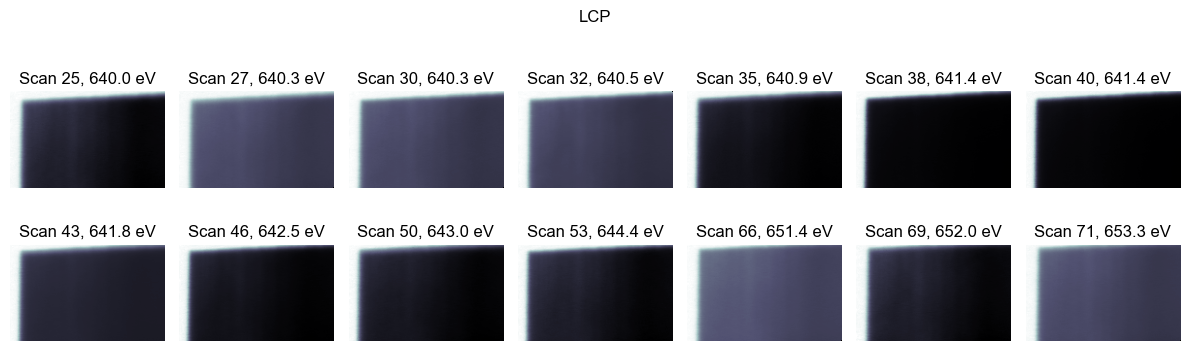

In [6]:
images = Ipc_lcp_list

nrows = 2
ncols = 7

fig, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 2*nrows))

ax1 = ax1.flatten()

for i, ax in enumerate(ax1):
    if  i < len(energy_list):
        ax.imshow(images[i], cmap='bone')#, vmin=0, vmax=1)
        ax.set_title('Scan %s, %.1f eV' % (scanNums_lcp[i], energy_list[i]))
        ax.axis('off')

    else:
        ax.axis('off')

    plt.suptitle('LCP')

plt.tight_layout()

In [7]:
# energy_list = []

I_rcp_list = []
Ipc_rcp_list = []

# Loading and processing the RCP data / C-
datasetDet = '/'+entryNumber+'/'+detector
datasetInst = '/'+entryNumber+'/instrument'
datasetColl = '/'+entryNumber+'/collection'

for i, (image_path_rcp) in enumerate(image_path_rcp_list):
    with h5py.File(image_path_rcp,'r') as f:

        # Experimental conditions
        energy = np.array(f[datasetDet+'/energy'][0])
        magneticField = np.array(f[datasetColl+'/magnetic_field/value'][0])

        scanRequest = np.array(f[datasetColl+'/scan_request/scan_request'])
        scanRequeststr = scanRequest[0].decode("utf-8")
        scanRequestdecoded = json.loads(scanRequeststr)

        innerRegions = scanRequestdecoded['innerRegions']

    #     for innerRegion in innerRegions:
    #         axes = innerRegion['axes']
    #         for axis in axes:
    #             n_points = axis['nPoints']
    #             trajectories = axis['trajectories']
    #             for trajectory in trajectories:
    #                 positioner_name = trajectory['positionerName']
    #                 if positioner_name == "FineY":
    #                     centerY = trajectory['center']
    #                     range_valueY = trajectory['range']
    #                     stepY = trajectory['step']
    # #                     print("FineY Trajectory Center:", centerY)
    # #                     print("FineY Trajectory Range:", range_valueY)
    # #                     print("FineY Trajectory Step:", stepY)
    #                 elif positioner_name == "FineX":
    #                     centerX = trajectory['center']
    #                     range_valueX = trajectory['range']
    #                     stepX = trajectory['step']
    # #                     print("FineX Trajectory Center:", centerX)
    # #                     print("FineX Trajectory Range:", range_valueX)
    # #                     print("FineX Trajectory Step:", stepX)
        
        for innerRegion in innerRegions:
            axes = innerRegion.get('axes', [])
            for axis in axes:
                if 'nPoints' in axis:
                    n_points = axis['nPoints']
                    # Process n_points if needed
                trajectories = axis['trajectories']
                for trajectory in trajectories:
                    positioner_name = trajectory['positionerName']
                    if positioner_name == "FineY":
                        if 'center' in trajectory:
                            centerY = trajectory['center']
                            range_valueY = trajectory['range']
                            stepY = trajectory['step']
                            # print("FineY Trajectory Center:", centerY)
                    elif positioner_name == "FineX":
                        if 'center' in trajectory:
                            centerX = trajectory['center']
                            range_valueX = trajectory['range']
                            stepX = trajectory['step']
                            # print("FineX Trajectory Center:", centerX)

        # print("Energy (eV):", energy)
        # energy_list.append(energy)
        # print("Magnetic field (mT):", magneticField)
        # # print(scanRequest)
        # print("Center positions (um):", centerX, ',', centerY)
        # print("Range (um):",range_valueX, ',', range_valueY)
        # print("Step (um):",stepX, ',', stepY)

        # Data
        I_rcp = f[datasetDet+'/data'][()]

        setpx = f[datasetDet+'/sample_x'][()]
        setpy = f[datasetDet+'/sample_y'][()]
        readx = f[datasetInst+'/sample_x/data'][()]
        ready = f[datasetInst+'/sample_y/data'][()]
        data = f[datasetInst+'/'+detector+'/data'][()]

        X,Y = np.meshgrid(setpx, setpy)

        Xq = readx-np.mean(readx)
        Yq = ready-np.mean(ready)
        X = X-np.mean(X)
        Y = Y-np.mean(Y)

        Ipc_rcp = griddata((Xq, Yq), data, (X, Y), method=interpolation, fill_value=0)

    I_rcp = np.flip(I_rcp,0)
    Ipc_rcp = np.flip(Ipc_rcp,0)
    
    I_rcp_list.append(I_rcp)
    Ipc_rcp_list.append(Ipc_rcp)

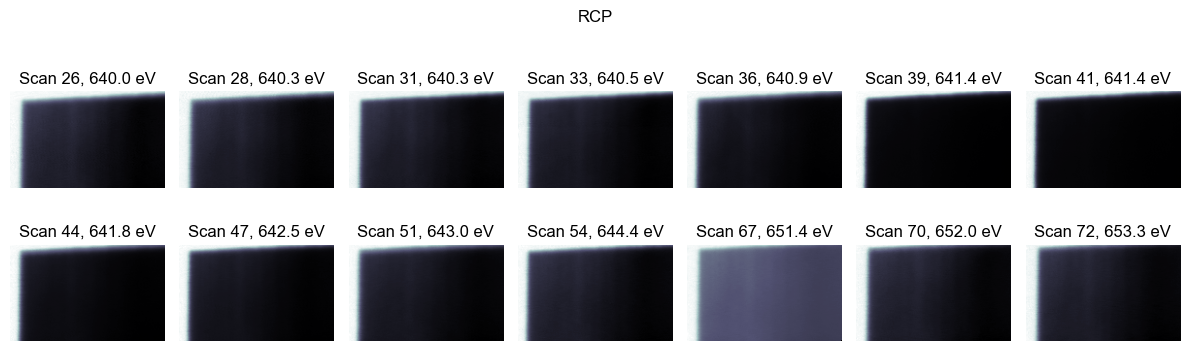

In [8]:
images = Ipc_rcp_list

nrows = 2
ncols = 7

fig, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 2*nrows))

ax1 = ax1.flatten()

for i, ax in enumerate(ax1):
    if  i < len(energy_list):
        ax.imshow(images[i], cmap='bone')#, vmin=0, vmax=1)
        ax.set_title('Scan %s, %.1f eV' % (scanNums_rcp[i], energy_list[i]))
        ax.axis('off')

    else:
        ax.axis('off')

    plt.suptitle('RCP')

plt.tight_layout()

# Alignment

## Pre-alignment

### Phase cross correlation

In [9]:
# base_images = norm_images_rcp
# ref_images = norm_images_lcp

# pre_aligned_images_rcp = []

# for i, image in enumerate(base_images):
#     vec, err, _ = phase_cross_correlation(ref_images[i], image, upsample_factor=100)

#     fft_image = np.fft.fftn(image)
#     shifted_fft_image = fourier_shift(fft_image, vec)
#     shifted_ifft_image = np.fft.ifftn(shifted_fft_image)

#     print(i, vec)

#     pre_aligned_images_rcp.append(shifted_ifft_image.real)

### Stackreg

In [9]:
base_images = Ipc_rcp_list
ref_images = Ipc_lcp_list

pre_aligned_images_rcp = []

for i, (image) in enumerate(base_images):
    _, pre_aligned_image = alignStackReg(ref_images[i], image)
    
    pre_aligned_images_rcp.append(pre_aligned_image)   

In [10]:
images_lcp = Ipc_lcp_list
images_rcp = pre_aligned_images_rcp

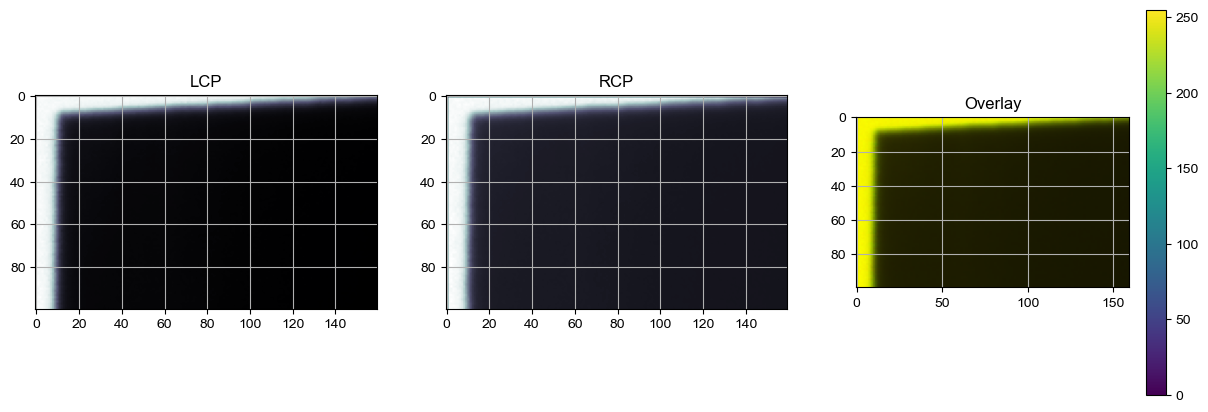

In [11]:
i = 6

overray = compositeImages([images_lcp[i], images_rcp[i]])

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
# fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#
im1=ax1.imshow(images_lcp[i], cmap='bone')#, vmin=0, vmax=1)
ax1.set_title('LCP')
ax1.grid()
#
im2=ax2.imshow(images_rcp[i], cmap='bone')#, vmin=0, vmax=1)
ax2.set_title('RCP')
ax2.grid()
#
im3=ax3.imshow((overray*255).astype(np.uint8))#, vmin=-1,vmax=1)
ax3.set_title('Overlay')
plt.colorbar(im3,ax=ax3)
ax3.grid()

## Fine alignment

### Skimage

In [12]:
blur_images_lcp = []

for i, (image) in enumerate(images_lcp):
    blur = filters.gaussian(image, sigma=1)
    blur_images_lcp.append(blur)

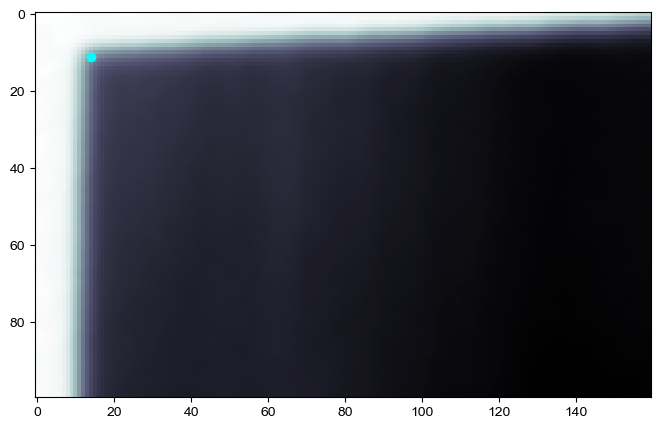

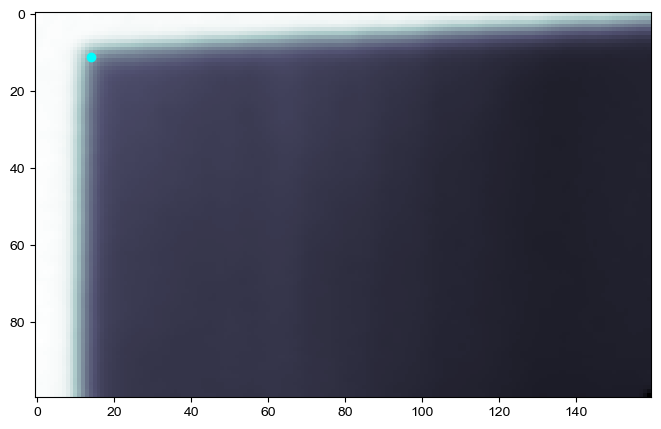

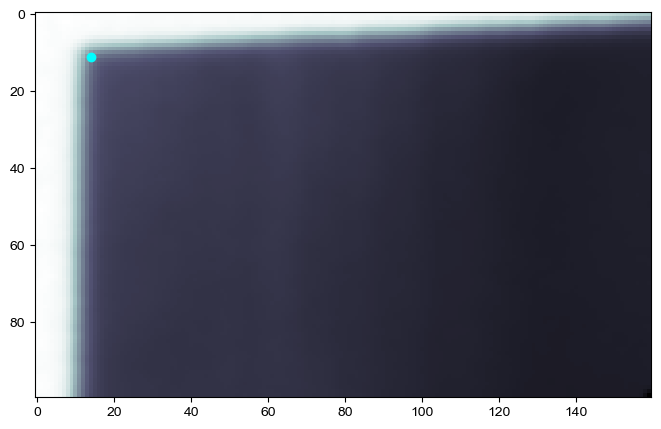

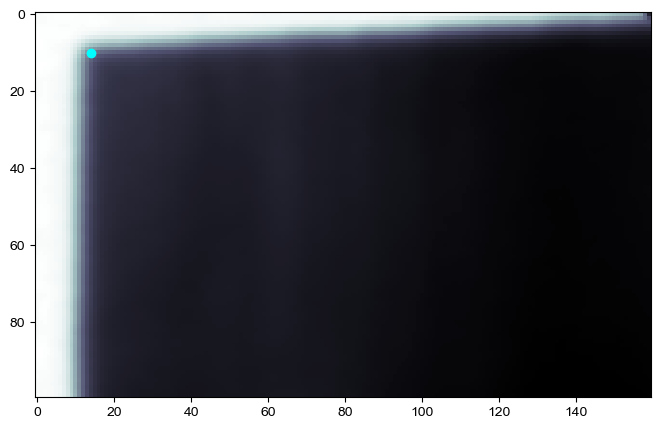

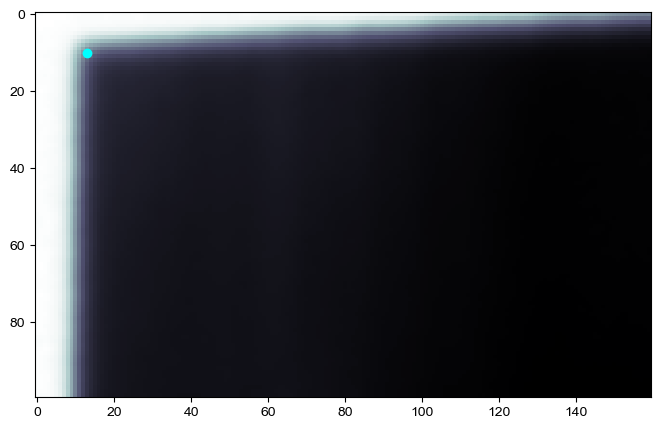

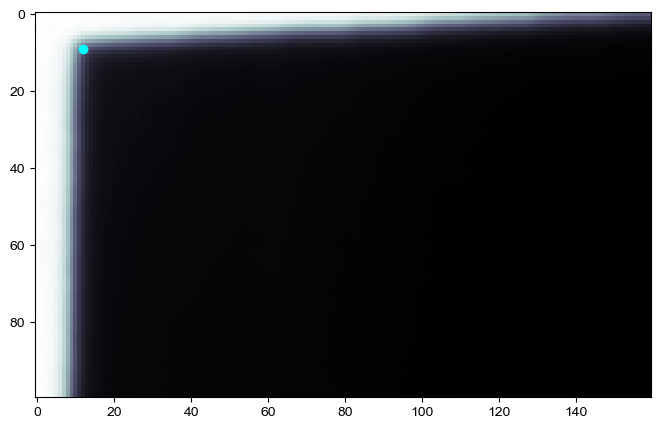

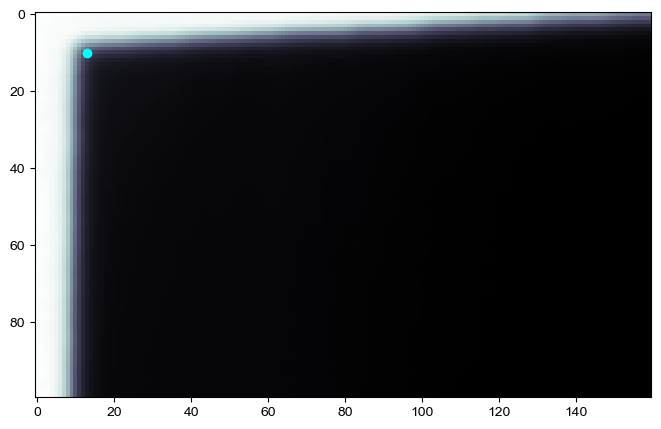

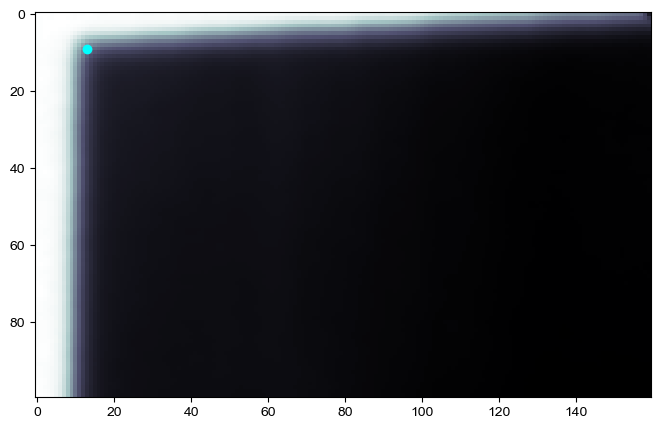

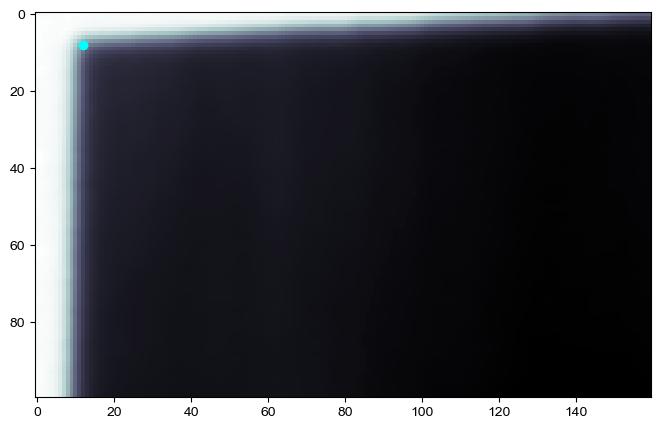

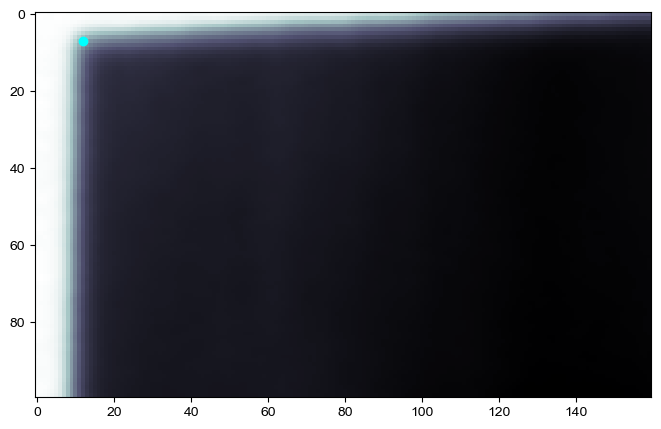

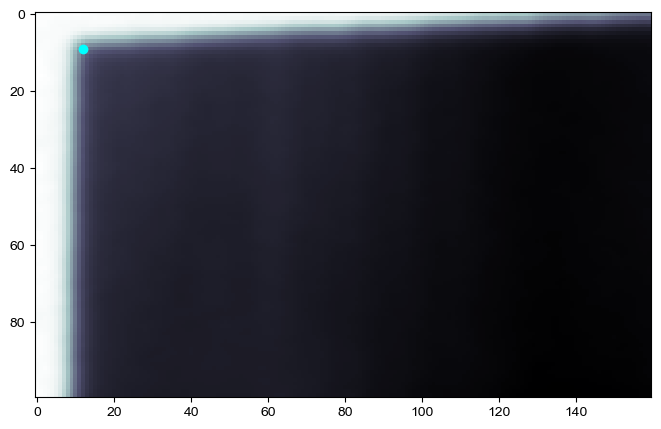

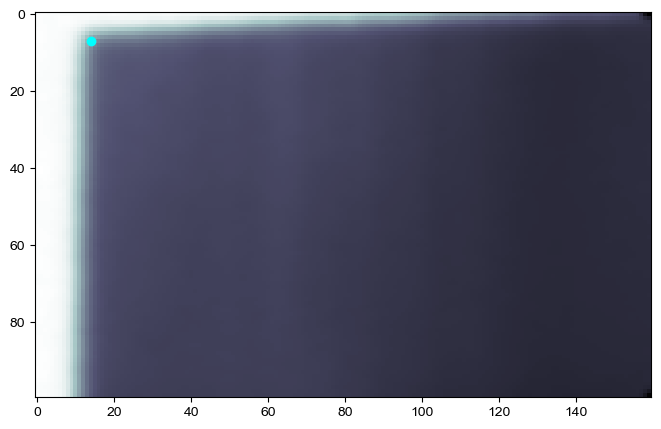

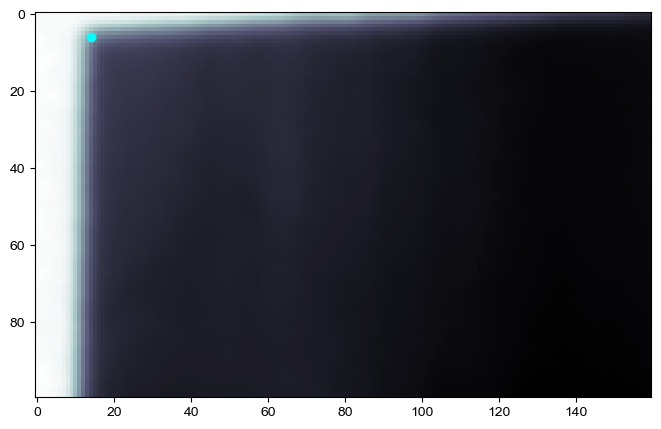

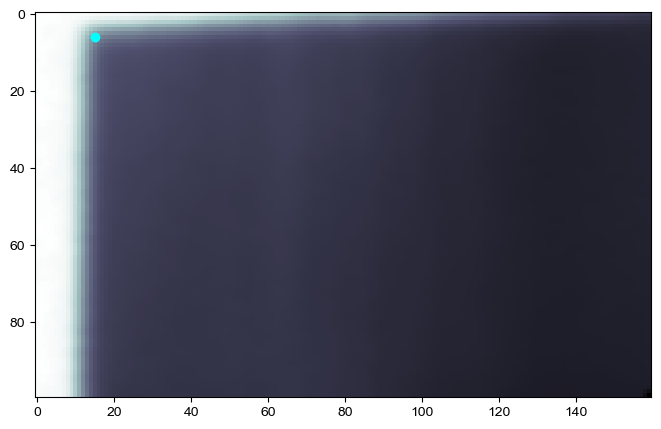

In [13]:
coords_list = []

for i, image in enumerate(blur_images_lcp):
    coords = corner_peaks(corner_harris(image), min_distance=2, threshold_rel=1e-6)
    # coords_subpix = corner_subpix(image, coords, window_size=5)
    
    # min_coord = np.min(coords[:, 0])
    # min_index = np.argmin(coords[:, 0])
    max_coord = np.max(coords[:, 0])
    max_index = np.argmax(coords[:, 0])
    
    coord = (coords[max_index, 1], coords[max_index, 0])
    # print(coord)
    
    coords_list.append(coord)
    
    fig,(ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    im1=ax1.imshow(image, cmap='bone')#, vmin=0, vmax=1)
    # ax1.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
    # ax1.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', linestyle='None', markersize=15)
    # ax1.plot(coords[min_index, 1], coords[min_index, 0], color='cyan', marker='o', linestyle='None', markersize=6)
    # ax1.plot(coords[max_index, 1], coords[max_index, 0], color='cyan', marker='o', linestyle='None', markersize=6)
    ax1.plot(coords_list[i][0], coords_list[i][1], color='cyan', marker='o', linestyle='None', markersize=6)

    # ax1.set_title('Alignment point')
    # ax1.grid()

In [14]:
aligned_images_lcp = []

for i, image in enumerate(images_lcp):
    diffx = int(coords_list[0][0] - coords_list[i][0])
    diffy = int(coords_list[0][1] - coords_list[i][1])
    # print(diffx, diffy)
    
    mat = np.float32([[1, 0, diffx], [0, 1, diffy]])
    shifted_image = cv2.warpAffine(image, mat, (image.shape[1], image.shape[0]))
    aligned_images_lcp.append(shifted_image)

In [15]:
aligned_images_rcp = []

for i, image in enumerate(pre_aligned_images_rcp):
    diffx = int(coords_list[0][0] - coords_list[i][0])
    diffy = int(coords_list[0][1] - coords_list[i][1])
    # print(diffx, diffy)
    
    mat = np.float32([[1, 0, diffx], [0, 1, diffy]])
    shifted_image = cv2.warpAffine(image, mat, (image.shape[1], image.shape[0]))
    aligned_images_rcp.append(shifted_image)

In [16]:
imageSlider(aligned_images_lcp, 0, 12000)

interactive(children=(IntSlider(value=0, description='index', max=13), Output()), _dom_classes=('widget-intera…

# Crop images

In [17]:
aligned_images_lcp[0].shape

(100, 160)

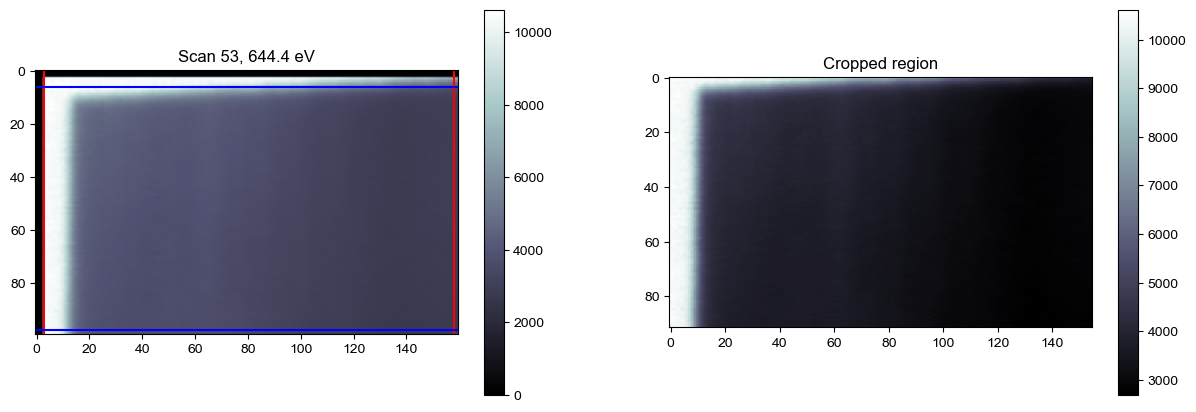

In [18]:
# Set ROI for normalization
i = 10
image = aligned_images_rcp[i]

crop_x0_lcp = 3
crop_x1_lcp = 158
crop_y0_lcp = 6
crop_y1_lcp = 98

fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#
im1=ax1.imshow(image, cmap='bone')#, vmin=10000,vmax=30000)
ax1.set_title('Scan %s, %.1f eV' % (scanNums_lcp[i], energy_list[i]))
plt.colorbar(im1,ax=ax1)
ax1.axvline(crop_x0_lcp,color='r')
ax1.axvline(crop_x1_lcp,color='r')
ax1.axhline(crop_y0_lcp,color='b')
ax1.axhline(crop_y1_lcp,color='b')

#
im2=ax2.imshow(image[crop_y0_lcp:crop_y1_lcp,crop_x0_lcp:crop_x1_lcp], cmap='bone')#, vmin=-0.1,vmax=0.1)
ax2.set_title('Cropped region')
plt.colorbar(im2,ax=ax2)

In [19]:
cropped_images_lcp = []
cropped_images_rcp = []

for i, image in enumerate(aligned_images_lcp):
    cropped_image = image[crop_y0_lcp:crop_y1_lcp, crop_x0_lcp:crop_x1_lcp]
    cropped_images_lcp.append(cropped_image)
    
for i, image in enumerate(aligned_images_rcp):
    cropped_image = image[crop_y0_lcp:crop_y1_lcp, crop_x0_lcp:crop_x1_lcp]
    cropped_images_rcp.append(cropped_image)

In [20]:
# Check if zero intensity region is not included
for i in range(len(cropped_images_lcp)):
    image_lcp = cropped_images_lcp[i]
    image_rcp = cropped_images_rcp[i]
    
    print(i)
    print("Min value in image_lcp:", np.min(image_lcp))
    print("Min value in image_rcp:", np.min(image_rcp))

0
Min value in image_lcp: 3699.992145177457
Min value in image_rcp: 3311.651611328125
1
Min value in image_lcp: 3104.7141714570253
Min value in image_rcp: 2802.008056640625
2
Min value in image_lcp: 2949.546765976216
Min value in image_rcp: 2598.312255859375
3
Min value in image_lcp: 2591.0575398088968
Min value in image_rcp: 2307.758056640625
4
Min value in image_lcp: 1819.241420797764
Min value in image_rcp: 1628.1597900390625
5
Min value in image_lcp: 1173.106042530209
Min value in image_rcp: 1025.1474609375
6
Min value in image_lcp: 1143.66186978891
Min value in image_rcp: 990.6221923828125
7
Min value in image_lcp: 1467.821580054549
Min value in image_rcp: 1274.430908203125
8
Min value in image_lcp: 1833.0105884254695
Min value in image_rcp: 1606.490478515625
9
Min value in image_lcp: 2434.3085280244545
Min value in image_rcp: 2132.406494140625
10
Min value in image_lcp: 3033.3487250360286
Min value in image_rcp: 2691.92919921875
11
Min value in image_lcp: 3155.806526535136
Min va

# XMCD

In [27]:
amax = 0.472

In [ ]:
norm_images_lcp = []
norm_images_rcp = []
norm_dimages_lcp = []
norm_dimages_rcp = []
images_xmcd = []

for i in range(len(cropped_images_lcp)):
    image_lcp = cropped_images_lcp[i]
    image_rcp = cropped_images_rcp[i]    
    
    # XMCD
    # image_xmcd = 100 * (norm_image_lcp - norm_image_rcp) #/ (norm_image_lcp + norm_image_rcp)
    
    image_xmcd = 100 * (norm_image_lcp - norm_image_rcp) / amax

    # image_xmcd = 100 * (np.log(norm_image_lcp) - np.log(norm_image_rcp)) / 2

    norm_images_lcp.append(norm_image_lcp)
    norm_images_rcp.append(norm_image_rcp)
    images_xmcd.append(image_xmcd)

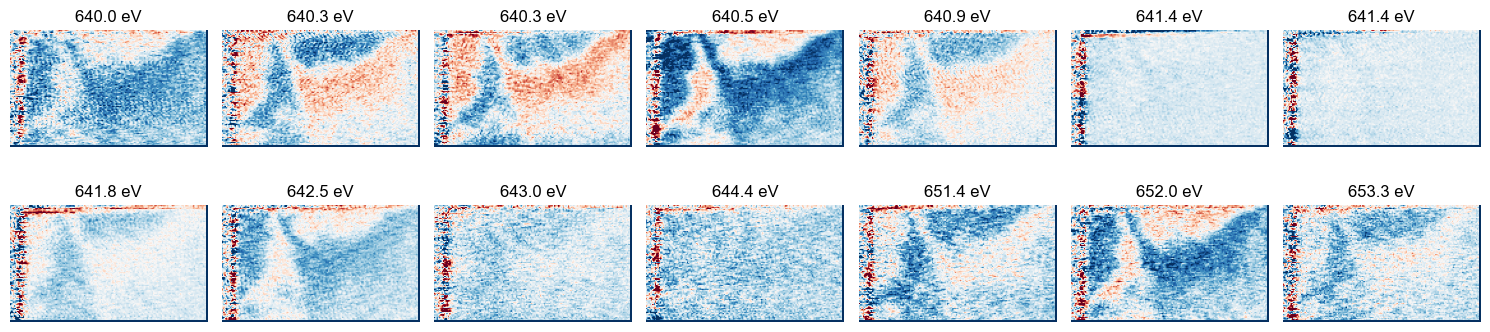

In [44]:
images = aligned_images_xmcd

nrows = 2
ncols = 7

fig, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))

ax1 = ax1.flatten()

for i, ax in enumerate(ax1):
    if  i < len(energy_list):
        ax.imshow(images[i], cmap='RdBu', vmin=-4, vmax=4)
        ax.set_title('%.1f eV' % (energy_list[i]))
        ax.axis('off')

    else:
        ax.axis('off')

    # plt.suptitle('XMCD')

plt.tight_layout()

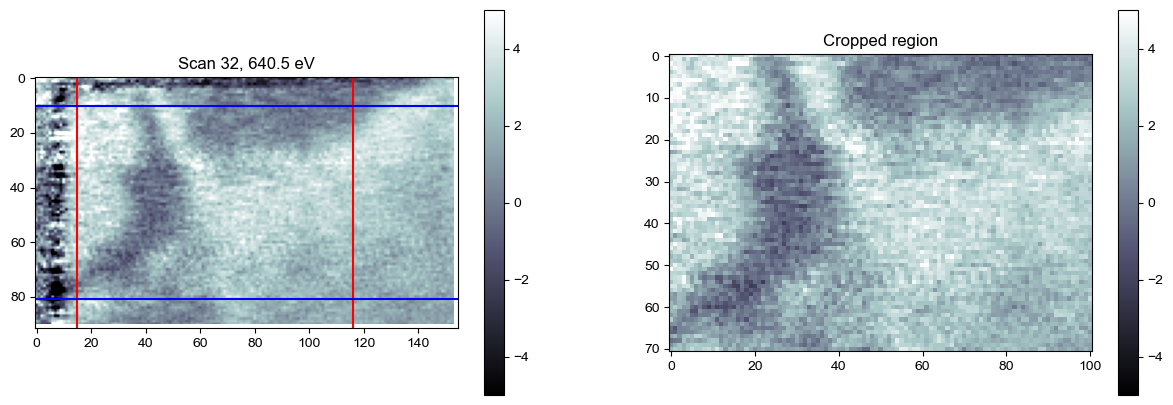

In [45]:
i = 3
image = aligned_dark_images_xmcd[i]

crop_x0 = 15
crop_x1 = 116
crop_y0 = 10
crop_y1 = 81

fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#
im1=ax1.imshow(image, cmap='bone', vmin=-5, vmax=5)
ax1.set_title('Scan %s, %.1f eV' % (scanNums_lcp[i], energy_list[i]))
plt.colorbar(im1,ax=ax1)
ax1.axvline(crop_x0,color='r')
ax1.axvline(crop_x1,color='r')
ax1.axhline(crop_y0,color='b')
ax1.axhline(crop_y1,color='b')

#
im2=ax2.imshow(image[crop_y0:crop_y1,crop_x0:crop_x1], cmap='bone', vmin=-5, vmax=5)
ax2.set_title('Cropped region')
plt.colorbar(im2,ax=ax2)

In [46]:
cropped_aligned_images_xmcd = []

for i, image in enumerate(aligned_images_xmcd):
    cropped_image = image[crop_y0:crop_y1, crop_x0:crop_x1]
    cropped_aligned_images_xmcd.append(cropped_image)

# Save images

In [65]:
save_path = ''
print(save_path)

C:/Users/yamamoto/Dropbox/MPI/Project/MnTe/Beamtime/BESSY_MAXYMUS_Jan2025/Analyzed/XMCD/Series/Cropped/


In [66]:
length = 2 # um
scalebar_length = length / stepX
print(stepX)
scalebar_color = 'black'
print(scalebar_length)

0.025
80.0


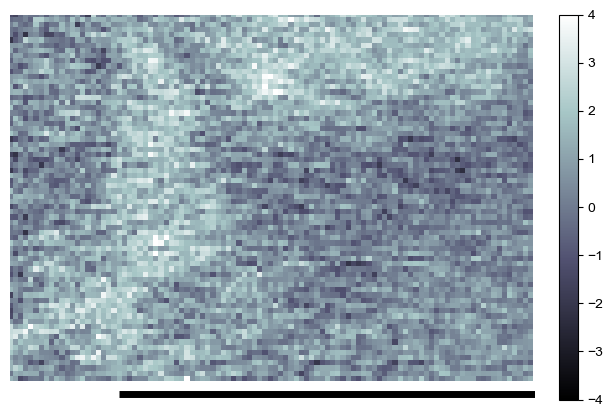

In [72]:
image = cropped_aligned_images_xmcd[13]
# image = cropped_aligned_dark_images_xmcd[13]

fig,(ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
#
im1=ax1.imshow(image, cmap='bone', vmin=-4, vmax=4)
plt.colorbar(im1, ax=ax1, pad=0.02)
# plt.colorbar(im1, ax=ax1, pad=0.02, ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

# Adjust axis limits to make room for the scale bar
ax1.set_ylim(image.shape[0]+3, 0)  # Expand bottom margin (negative values extend below)
ax1.set_xlim(0, image.shape[1])

# Add scale bar using axhline
# scale_bar_y = 95  # Vertical position (outside the image in data coordinates)
scale_bar_y = 73 # Vertical position (outside the image in data coordinates)
scale_bar_x_start = image.shape[1] - scalebar_length # Start position (in data coordinates)
scale_bar_x_end = image.shape[1]  # End position (length of the scale bar)

ax1.hlines(
    y=scale_bar_y,  # Vertical position of the line
    xmin=scale_bar_x_start,  # Start of the scale bar
    xmax=scale_bar_x_end,  # End of the scale bar
    colors=scalebar_color,
    linewidth=5,
    )

ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')

image_png = save_path + 'w_scalebar' + '.png'
# print(image_png)
plt.savefig(image_png, dpi=300, bbox_inches='tight', pad_inches=0)
# plt.close()  # Close the figure to free up memory

# # image_npy = save_image_path + fname + '.npy'
# # np.save(image_npy, image)
# # # np.save(image_npy, blur)

In [73]:
images = cropped_aligned_images_xmcd
# images = cropped_aligned_dark_images_xmcd
# images = norm_dimages_lcp
# images = norm_dimages_rcp

for i, image in enumerate(images):
    fig,(ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

    #
    im1=ax1.imshow(image, cmap='bone', vmin=-4, vmax=4)
    # blur = filters.gaussian(image, sigma=1)
    # im1=ax1.imshow(blur, cmap='bone', vmin=-0.03, vmax=0.03)
    # ax1.set_title('XMCD')
    # plt.colorbar(im1,ax=ax1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.axis('off')

    fname = 'cropped_aligned_images_xmcd_%.2feV_%03d_%03d' %(energy_list[i], scanNums_lcp[i], scanNums_rcp[i])
    # fname = 'cropped_aligned_dark_images_xmcd_%.2feV_%03d_%03d' %(energy_list[i], scanNums_lcp[i], scanNums_rcp[i])
    print(fname)

    image_png = save_path + fname + '.png'
    # print(image_png)
    plt.savefig(image_png, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to free up memory

    image_npy = save_path + fname + '.npy'
    np.save(image_npy, image)
    # np.save(image_npy, blur)

cropped_aligned_images_xmcd_640.05eV_025_026
cropped_aligned_images_xmcd_640.30eV_027_028
cropped_aligned_images_xmcd_640.30eV_030_031
cropped_aligned_images_xmcd_640.55eV_032_033
cropped_aligned_images_xmcd_640.90eV_035_036
cropped_aligned_images_xmcd_641.40eV_038_039
cropped_aligned_images_xmcd_641.40eV_040_041
cropped_aligned_images_xmcd_641.80eV_043_044
cropped_aligned_images_xmcd_642.45eV_046_047
cropped_aligned_images_xmcd_643.00eV_050_051
cropped_aligned_images_xmcd_644.40eV_053_054
cropped_aligned_images_xmcd_651.40eV_066_067
cropped_aligned_images_xmcd_652.00eV_069_070
cropped_aligned_images_xmcd_653.30eV_071_072


# Spectra

In [429]:
images = cropped_aligned_images_xmcd
# images = cropped_aligned_dark_images_xmcd
blur_images_xmcd = []

for i, (image) in enumerate(images):
    blur = filters.gaussian(image, sigma=1)
    blur_images_xmcd.append(blur)

In [430]:
pos0 = [25, 30] # Left top
pos1 = [45, 30] 

width = 5 
height = 5

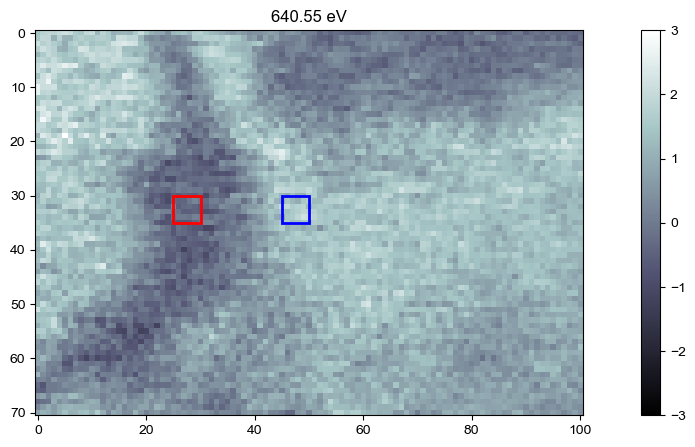

In [431]:
i = 3
# image = cropped_aligned_dark_images_xmcd[i]
image = cropped_aligned_images_xmcd[i]

fig,(ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

#
im1=ax1.imshow(image, cmap='bone', vmin=-3,vmax=3)
ax1.set_title('%s eV' %(energy_list[i]))
plt.colorbar(im1,ax=ax1)
ax1.add_patch(Rectangle(pos0, width, height, facecolor ='none',  edgecolor ='red', linewidth = 2))
ax1.add_patch(Rectangle(pos1, width, height, facecolor ='none',  edgecolor ='blue', linewidth = 2))
# ax1.axis('off')
# ax1.grid()

# image_png = save_image_path + 'spectra_pos' + '.png'
# # print(image_png)
# plt.savefig(image_png, dpi=300, bbox_inches='tight', pad_inches=0)
# # plt.close()  # Close the figure to free up memory

# # image_npy = save_image_path + fname + '.npy'
# # np.save(image_npy, image)
# # # np.save(image_npy, blur)

In [432]:
images = blur_images_xmcd

int0_list = []
int1_list = []
intdiff_list = []

for i, (image) in enumerate(images):
    int0 = np.mean(image[pos0[1]:pos0[1]+height,pos0[0]:pos0[0]+width])
    # print(int0)

    int1 = np.mean(image[pos1[1]:pos1[1]+height,pos1[0]:pos1[0]+width])
    # print(int1)
    
    int0_list.append(int0)
    int1_list.append(int1)

    intdiff = (int0 - int1) / 2
    intdiff_list.append(intdiff)
    
    # print(i, int0, int1, intdiff)

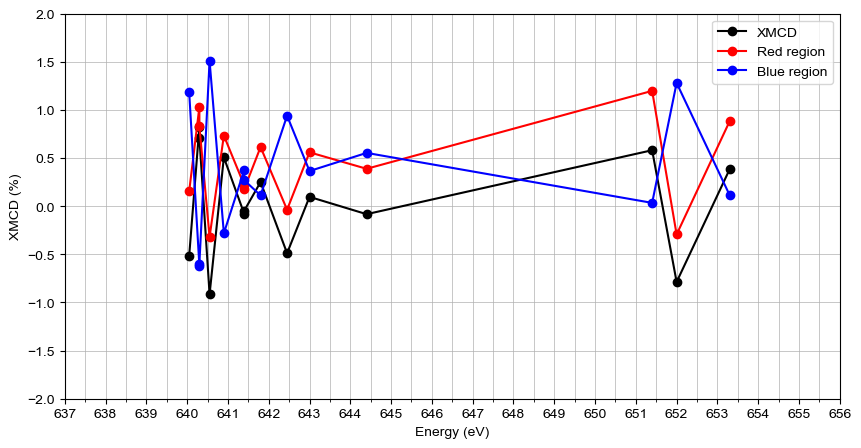

In [435]:
fig,(ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

#
im1=ax1.plot(energy_list, intdiff_list, color='black', marker='o', label='XMCD')
im1=ax1.plot(energy_list, int0_list, color='red', marker='o', label='Red region')
im1=ax1.plot(energy_list, int1_list, color='blue', marker='o', label='Blue region')

major_ticks = np.arange(629.0, 663.0, 1)
minor_ticks = np.arange(629.0, 663.0, 0.5)

ax = plt.gca()  # Get the current axes
ax.grid(True, which='both', linewidth=0.5)  # Add grid
# plt.title("Intensity Profile Along Selected Line")
plt.xlabel('Energy (eV)')
# plt.ylabel('Transmission')
plt.ylabel('XMCD (%)')
plt.legend()

major_ticks = np.arange(629.0, 663.0, 1)
minor_ticks = np.arange(629.0, 663.0, 0.5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

ax.set_xlim(637.0, 656.0)
ax.set_ylim(-2, 2)

plt.show()